In [2]:
import warnings

warnings.filterwarnings('ignore')



In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load your data
df = pd.read_json('drug_dictionary_number.json')



In [4]:
import pandas as pd


# Assuming df is your original DataFrame

# Expanding the 'uses' dictionary into separate DataFrame columns
uses_df = df['uses'].apply(pd.Series)
uses_df = uses_df.add_prefix('uses_')

# Expanding the 'categorized_serious_effects' dictionary into separate DataFrame columns
serious_effects_df = df['categorized_serious_effects'].apply(pd.Series)
serious_effects_df = serious_effects_df.add_prefix('side_effects_')

# Assuming 'ingredients' is also a dictionary and needs to be expanded into separate columns
ingredients_df = df['ingredients'].apply(pd.Series)
ingredients_df = ingredients_df.add_prefix('ingredient_')

# Combine the expanded columns with the original dataframe, excluding the original dictionary columns
df = pd.concat([df.drop(['uses', 'ingredients', 'categorized_serious_effects'], axis=1), uses_df, ingredients_df, serious_effects_df], axis=1)
# For each drug class, create a new column in df

# Assuming df is your DataFrame and 'drug_classes' is a column of lists
all_drug_classes = set()

# Iterate over the column to collect unique drug classes
for drug_classes in df['drug_classes']:
    all_drug_classes.update(drug_classes)

# Create a new DataFrame for the binary columns
binary_columns = pd.DataFrame()

# Generate binary columns
for drug_class in all_drug_classes:
    binary_columns[drug_class] = df['drug_classes'].apply(lambda x: 1 if drug_class in x else 0)

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, binary_columns], axis=1)

# Optionally, drop the original 'drug_classes' column
df = df.drop('drug_classes', axis=1)


# Fill NA values with 0 or another appropriate value
df = df.fillna(0)

# Display the first few rows of the updated DataFrame
df.head()


,name,status,generic_name,betweenness_score,closeness_score,degree_score,uses_Infectious Diseases,uses_Neurological Disorders,uses_Gastrointestinal Disorders,uses_Cardiovascular Diseases,...,Antithyroid agents,Carbapenems,Tetracyclines,Thrombin inhibitors,AMPA receptor antagonists,Tetracyclic antidepressants,Mydriatics,Methylxanthines,Antimetabolites,Miscellaneous antituberculosis agents
0,Azulfidine,Prescription only,sulfasalazine,0.070434,0.806840,0.280775,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Abstral,Discontinued,fentanyl,0.046356,0.892619,0.679413,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aczone,Prescription only,dapsone-topical,0.075351,0.717960,0.108434,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adzynma,Prescription only,"adamts13, recombinant-krhn",0.000000,0.000000,0.000000,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Adzenys XR-ODT,Prescription only,amphetamine,0.011006,0.774746,0.242535,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Define your target variable
y = df['status'].apply(lambda x: 1 if x == 'Prescription only' or x == 'Discontinued' else 0)
X = df.drop(['status', 'generic_name', 'name'], axis=1)  # Assuming all other columns are features


              precision    recall  f1-score   support

           0       0.84      0.88      0.86      2384
           1       0.95      0.93      0.94      5494

    accuracy                           0.91      7878
   macro avg       0.89      0.91      0.90      7878
weighted avg       0.92      0.91      0.91      7878



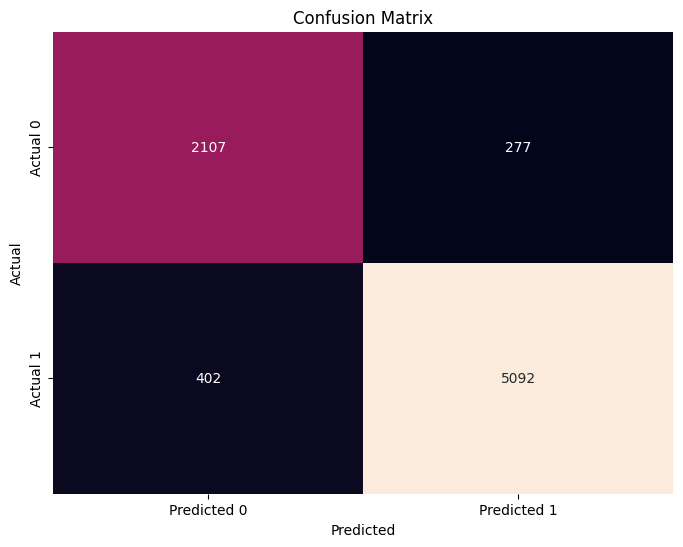

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

# Assuming X and y are already defined
# model = LogisticRegression(max_iter=1000)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store metrics and labels
threshold_metrics = []
true_labels = []
predicted_labels = []

# Custom threshold
threshold = 0.55

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    y_pred_threshold = np.where(y_prob[:, 1] >= threshold, 1, 0)
    
    report = classification_report(y_test, y_pred_threshold, output_dict=True)
    threshold_metrics.append(report)

    true_labels.extend(y_test)
    predicted_labels.extend(y_pred_threshold)

# Process the collected metrics
metrics_dfs = [pd.DataFrame(report).transpose() for report in threshold_metrics]
all_metrics_df = pd.concat(metrics_dfs, axis=0)
avg_metrics = all_metrics_df.groupby(all_metrics_df.index).mean()
avg_metrics.to_csv('classification_report_with_custom_threshold.csv')

# Generate overall classification report
report = classification_report(true_labels, predicted_labels)
print(report)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
